In [1]:
!unzip /content/Face-Images

Archive:  /content/Face-Images.zip
   creating: Face Images/
  inflating: Face Images/.DS_Store   
   creating: __MACOSX/
   creating: __MACOSX/Face Images/
  inflating: __MACOSX/Face Images/._.DS_Store  
   creating: Face Images/Final Training Images/
  inflating: Face Images/Final Training Images/.DS_Store  
   creating: __MACOSX/Face Images/Final Training Images/
  inflating: __MACOSX/Face Images/Final Training Images/._.DS_Store  
   creating: Face Images/Final Training Images/face12/
  inflating: Face Images/Final Training Images/face12/image_0281_Face_1.jpg  
   creating: __MACOSX/Face Images/Final Training Images/face12/
  inflating: __MACOSX/Face Images/Final Training Images/face12/._image_0281_Face_1.jpg  
  inflating: Face Images/Final Training Images/face12/image_0284_Face_1.jpg  
  inflating: __MACOSX/Face Images/Final Training Images/face12/._image_0284_Face_1.jpg  
  inflating: Face Images/Final Training Images/face12/image_0283_Face_2.jpg  
  inflating: __MACOSX/Face Ima

In [2]:
import numpy as np
import warnings
import pickle
import time
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

In [20]:
from keras.callbacks import EarlyStopping

In [21]:
def build_unet_autoencoder(input_shape):
    input_img = Input(shape=input_shape)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Decoder
    up4 = concatenate([UpSampling2D(size=(2, 2))(conv3), conv2], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(up4)
    up5 = concatenate([UpSampling2D(size=(2, 2))(conv4), conv1], axis=-1)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up5)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    return autoencoder

# Function to preprocess image data and train autoencoder
def train_autoencoder(train_datagen, test_datagen, input_shape, epochs):
    autoencoder = build_unet_autoencoder(input_shape)

    # Retrieve data generators
    training_set = train_datagen.flow_from_directory(trainpath, target_size=(64, 64), batch_size=32, class_mode='input')
    test_set = test_datagen.flow_from_directory(testpath, target_size=(64, 64), batch_size=32, class_mode='input')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

    # Train autoencoder
    StartTime = time.time()
    autoencoder.fit(training_set, steps_per_epoch=len(training_set), epochs=epochs,
                    validation_data=test_set, validation_steps=len(test_set),
                    callbacks=[early_stopping])
    EndTime = time.time()

    return autoencoder, EndTime - StartTime

In [22]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [25]:
trainpath = '/content/Face Images/Final Training Images'
testpath = '/content/Face Images/Final Testing Images'



In [28]:
from keras.layers import concatenate
autoencoder, training_time = train_autoencoder(train_datagen, test_datagen, (64, 64, 3), epochs=20)

Found 244 images belonging to 16 classes.
Found 64 images belonging to 16 classes.
Epoch 1/20
8/8 [==============================] - 33s 4s/step - loss: 0.0508 - val_loss: 0.0369
Epoch 2/20
8/8 [==============================] - 32s 4s/step - loss: 0.0354 - val_loss: 0.0207
Epoch 3/20
8/8 [==============================] - 33s 4s/step - loss: 0.0230 - val_loss: 0.0211
Epoch 4/20
8/8 [==============================] - 31s 4s/step - loss: 0.0176 - val_loss: 0.0171
Epoch 5/20
8/8 [==============================] - 31s 4s/step - loss: 0.0140 - val_loss: 0.0136
Epoch 6/20
8/8 [==============================] - 33s 4s/step - loss: 0.0113 - val_loss: 0.0106
Epoch 7/20
8/8 [==============================] - 31s 4s/step - loss: 0.0094 - val_loss: 0.0102
Epoch 8/20
8/8 [==============================] - 33s 4s/step - loss: 0.0084 - val_loss: 0.0076
Epoch 9/20
8/8 [==============================] - 33s 4s/step - loss: 0.0069 - val_loss: 0.0065
Epoch 10/20
8/8 [==============================] - 31

In [29]:
autoencoder.save('autoencoder_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [30]:
from keras.models import load_model
autoencoder = load_model('autoencoder_model.h5')

In [31]:
TrainClasses=training_set.class_indices

NameError: name 'training_set' is not defined

In [32]:
with open("ResultsMap.pkl", 'wb') as fileWriteStream:
    pickle.dump(ResultMap, fileWriteStream)

In [33]:
with open("ResultsMap.pkl", 'rb') as fileReadStream:
    ResultMap = pickle.load(fileReadStream)

In [34]:
ImagePath = '/content/Face Images/Final Testing Images/face12/1face12.jpg'
test_image = image.load_img(ImagePath, target_size=(64, 64))
test_input = image.img_to_array(test_image)
test_input = np.expand_dims(test_input, axis=0) / 255.

In [35]:
denoised_image = autoencoder.predict(test_input)

1/1 [==============================] - 0s 125ms/step


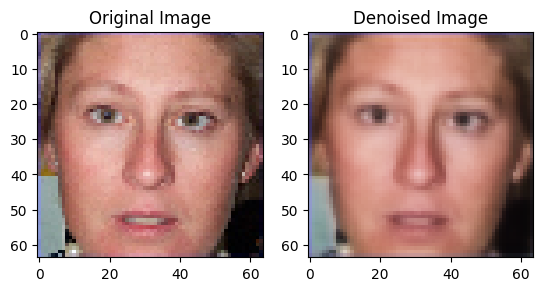

In [36]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(test_input[0])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(denoised_image[0])
plt.title('Denoised Image')
plt.show()